In [1]:
import plotly
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected = True)
import numpy as np
import ipywidgets as widgets
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import json

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
#import plotly.plotly as py

In [35]:
import plotly.graph_objs as go
go.FigureWidget(layout={'title': '$\LaTeX$'})

FigureWidget({
    'data': [], 'layout': {'template': '...', 'title': {'text': '$\\LaTeX$'}}
})

In [3]:
#define widgets here
co2_ppm = widgets.Dropdown(
    options=['0', '10', '100', '1000'],
    value='10',
    description='CO2[ppm]:',
    disabled=False,
)
options_gases = ['T(K)','Pressure(mbar)','O2(atm cm/km)','N2(mol/cm2)']
#options_gases = ['T(K)','Pressure(mbar)','Water vapor(mbar)', 
#                           'Ozone(ppm)', 'CO2(ppm)','CO2(uatm)','CH4(ppm)','CH4(uatm)']
dropdown_atoms_profiles = widgets.Dropdown(
                    options=options_gases,
                    value='T(K)',
                    description='X-axis data:',
                    disabled=False,
)

In [4]:
dict_atmospheric = {options_gases[0]:'t',options_gases[1]:'p',options_gases[2]:'o2',options_gases[3]:'n2' }

In [5]:
## from: https://stackoverflow.com/questions/22417484/plancks-formula-for-blackbody-spectrum
import scipy as sp
import math
import matplotlib.pyplot as plt
import numpy as np
pi = np.pi
h = 6.626e-34
c = 3.0e+8
k = 1.38e-23

def planck(wav, T):
    a = 2.0*h*pi*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    return intensity

wavelengths = np.arange(1e-6, 30e-6, 2e-7) 

# intensity at 220, 240, 260, 280 and 300 K
intensity220 = planck(wavelengths, 220.)/(1e6)
intensity240 = planck(wavelengths, 240.)/(1e6)
intensity260 = planck(wavelengths, 260.)/(1e6)
intensity280 = planck(wavelengths, 280.)/(1e6)
intensity300 = planck(wavelengths, 300.)/(1e6)
#plt.plot(wavelengths*1e6, intensity220, 'r-') 
# plot intensity4000 versus wavelength in nm as a red line
# plt.plot(wavelengths*1e6, intensity240, 'g-') 
# plt.plot(wavelengths*1e6, intensity260, 'b-') 
# plt.plot(wavelengths*1e6, intensity280, 'k-') 
# plt.plot(wavelengths*1e6, intensity300, 'm-')

In [6]:
# load the index json file-- for different co2 conc
with open('toc_files.json','r') as infile:
    co2_dict = json.load(infile)

In [7]:
#build default values for widget 1
dir_name = Path(co2_dict[co2_ppm.value])
pqfile = dir_name / 'rad_spectrum.pq'
df = pd.read_parquet(pqfile)
x_values = df[df.keys()[1]]
scaled_intensity = (df[df.keys()[-1]]*planck(df[df.keys()[1]]*1e-6,300.))/1e6
trace0 = go.Scatter(x=x_values,  y=scaled_intensity, mode="lines", name = 'Model')
bbr_220 = go.Scatter(x=wavelengths*1e6, y=intensity220, mode="lines", name = '220 K')
bbr_240 = go.Scatter(x=wavelengths*1e6, y=intensity240, mode="lines", name = '240 K')
bbr_260 = go.Scatter(x=wavelengths*1e6, y=intensity260, mode="lines", name = '260 K')
bbr_280 = go.Scatter(x=wavelengths*1e6, y=intensity280, mode="lines", name = '280 K')
bbr_300 = go.Scatter(x=wavelengths*1e6, y=intensity300, mode="lines", name = '300 K')

# Now build the figure and define non-default parameters for this figure
g = go.FigureWidget(data=[trace0,bbr_220,bbr_240,bbr_260,bbr_280,bbr_300], 
                    layout=go.Layout(title=dict(text='Radiation spectrum')))
g.layout.width = 600
g.layout.height = 400
g.layout.xaxis.title = r'$\text{Wavelength in} \mu \text{m}$'
g.layout.yaxis.title = 'Intensity(W/m2 micron)'
g.layout.xaxis.range = [5.,25.]

In [8]:
df.keys()[:]

Index(['freq_invcm', 'wavlen_um', 'path_thermal_cm', 'path_thermal_mum',
       'surface_emission_cm', 'surface_emission_umu', 'surface_reflected_cm',
       'surface_reflected_mum', 'total_radiance_cm', 'total_radiance_mum',
       'integral_cm', 'total_trans'],
      dtype='object')

Text(0, 0.5, 'total_trans')

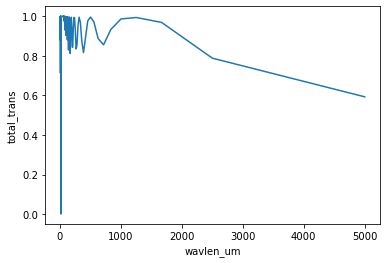

In [9]:
plt.plot(df[df.keys()[1]],df[df.keys()[-1]])
plt.xlabel('{}'.format(df.keys()[1]))
plt.ylabel('{}'.format(df.keys()[-1]))

In [10]:
bbr300 = planck(wavelengths,300.)/(1e6)

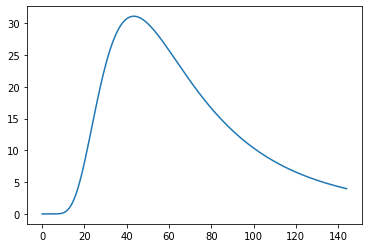

In [11]:
plt.plot(bbr300)

In [12]:
intensity300

array([5.26313555e-13, 6.32038015e-10, 8.88057950e-08, 3.31364220e-06,
       5.15974650e-05, 4.38843029e-04, 2.41648148e-03, 9.64062994e-03,
       3.01052318e-02, 7.77297921e-02, 1.72686280e-01, 3.40047752e-01,
       6.07032741e-01, 9.99586878e-01, 1.53913196e+00, 2.24010924e+00,
       3.10862230e+00, 4.14218868e+00, 5.33040959e+00, 6.65627392e+00,
       8.09780411e+00, 9.62979356e+00, 1.12254504e+01, 1.28578295e+01,
       1.45009923e+01, 1.61308794e+01, 1.77259086e+01, 1.92673325e+01,
       2.07393954e+01, 2.21293317e+01, 2.34272483e+01, 2.46259240e+01,
       2.57205583e+01, 2.67084923e+01, 2.75889199e+01, 2.83626045e+01,
       2.90316093e+01, 2.95990477e+01, 3.00688571e+01, 3.04455994e+01,
       3.07342853e+01, 3.09402246e+01, 3.10688990e+01, 3.11258563e+01,
       3.11166239e+01, 3.10466386e+01, 3.09211927e+01, 3.07453909e+01,
       3.05241199e+01, 3.02620261e+01, 2.99635016e+01, 2.96326760e+01,
       2.92734140e+01, 2.88893165e+01, 2.84837252e+01, 2.80597301e+01,
      

In [13]:
L = np.convolve(df[df.keys()[-1]],bbr300,mode='same')

In [14]:
L

array([1238.42199099, 1257.5998051 , 1276.42382022, ...,  716.37670138,
        696.38778907,  676.85316776])

In [15]:
intensity_planck = planck(df[df.keys()[1]]*1e-6,300.)/(1e6)
total_transm = df[df.keys()[-1]]

In [16]:
#L1 = np.convolve(intensity_planck,total_transm,mode='')

In [17]:
#L1

In [18]:
#from scipy import signal

In [19]:
#plt.plot(signal.convolve(df[df.keys()[-1]],bbr300))

In [20]:
#scipy.

In [21]:
#L.size

In [22]:
#L

In [23]:
#plt.plot(L1)
#plt.plot()

In [24]:
# plt.plot(df[df.keys()[1]],df[df.keys()[-1]])
# plt.plot(df[df.keys()[1]],L1)
# plt.xlabel('{}'.format(df.keys()[1]))
# plt.ylabel('{}'.format(df.keys()[-1]))
# #plt.xlim([0,30])

In [25]:
x1_values = df[df.keys()[1]]
y1_values = df[df.keys()[-3]]
trace1 = go.Scatter(x=x1_values, y=y1_values, mode="lines")

# Now build the figure and define non-default parameters for this figure
g1 = go.FigureWidget(data=[trace1], 
                    layout=go.Layout(title=dict(text='Total radiance spectrum')))
g1.layout.width = 600
g1.layout.height = 400
g1.layout.xaxis.title = r"$\text{Wavelength in} \mu \text{m}$"
#g1.layout.yaxis.title = 'Total_radiance'
g1.layout.xaxis.range = [5.,25.]

In [26]:
# load the atmospheric profiles
the_dir = co2_dict[co2_ppm.value]
keep_profs = dict()
profs=['mol_prof.pq','aero_prof.pq','o3_prof.pq']
for a_prof in profs:
    the_file = Path(the_dir) / a_prof
    key=the_file.stem
    keep_profs[key] = pd.read_parquet(the_file)

In [27]:
x2_values = keep_profs['mol_prof']['t']
y2_values = keep_profs['mol_prof']['z']
trace2 = go.Scatter(x=x2_values, y=y2_values, mode="lines")

# Now build the figure and define non-default parameters for this figure
g2 = go.FigureWidget(data=[trace2], 
                    layout=go.Layout(title=dict(text='Mol_prof')))
g2.layout.width = 300
g2.layout.height = 500
g2.layout.xaxis.title = dropdown_atoms_profiles.value
g2.layout.yaxis.title = 'Altitude z (km)'
#g2.layout.xaxis.range = [5.,25.]

In [28]:
# plt.plot(keep_profs['mol_prof']['t'], keep_profs['mol_prof']['z'])

# plt.plot(keep_profs['o3_prof']['mol_scat'], keep_profs['o3_prof']['z'])

# plt.plot(keep_profs['o3_prof']['o2'], keep_profs['o3_prof']['z'])

# plt.plot(keep_profs['o3_prof']['p'], keep_profs['aero_prof']['z'])

# plt.plot(keep_profs['o3_prof']['n2'], keep_profs['o3_prof']['z'])

# keep_profs.keys()

In [29]:
def rad_spec_1(change):
    dir_name = Path(co2_dict[co2_ppm.value])
    pqfile = dir_name / 'rad_spectrum.pq'
    df = pd.read_parquet(pqfile)
    wavelength_um = df[df.keys()[1]]
    tot_transm = df[df.keys()[-1]]
    total_rad = df[df.keys()[-3]]
    scaled_intensity = (tot_transm*planck(df[df.keys()[1]]*1e-6,300.))/1e6
    g.data[0].x = wavelength_um
    g.data[0].y = scaled_intensity
    g.layout.xaxis.gridwidth = 1
    g.layout.xaxis.title = r'Wavelength in $\mu$m'
    g.layout.xaxis.range = [5.,25.]

    
# The next few calls I don't really understand. 
# Presumably I have to look up what the "observe" method is for "widget" objects. 
# It seems as if the "observe" method needs two parameters: 1) the function to call and 2) the "names" parameters. 
# `names="value"` seems to be saying: "pass these parameters with their values into the 'response' function". 
# Or something like that.

co2_ppm.observe(rad_spec_1, names="value")

In [30]:
def rad_spec_2(change):
    dir_name = Path(co2_dict[co2_ppm.value])
    pqfile = dir_name / 'rad_spectrum.pq'
    df = pd.read_parquet(pqfile)
    wavelength_um = df[df.keys()[1]]
    tot_transm = df[df.keys()[-1]]
    total_rad = df[df.keys()[-3]]
    scaled_intensity = (tot_transm*planck(df[df.keys()[1]]*1e-6,300.))/1e6
    g1.data[0].x = wavelength_um
    g1.data[0].y = total_rad
    g1.layout.xaxis.title = r'Wavelength in $\mu$m'

    
# The next few calls I don't really understand. 
# Presumably I have to look up what the "observe" method is for "widget" objects. 
# It seems as if the "observe" method needs two parameters: 1) the function to call and 2) the "names" parameters. 
# `names="value"` seems to be saying: "pass these parameters with their values into the 'response' function". 
# Or something like that.

co2_ppm.observe(rad_spec_2, names="value")

In [31]:
def atmos_profile(change):
    the_dir = co2_dict[co2_ppm.value]
    keep_profs = dict()
    profs=['mol_prof.pq','aero_prof.pq','o3_prof.pq']
    for a_prof in profs:
        the_file = Path(the_dir) / a_prof
        key=the_file.stem
        keep_profs[key] = pd.read_parquet(the_file)
    
    x2_values = keep_profs['o3_prof'][dict_atmospheric[dropdown_atoms_profiles.value]]
    y2_values = keep_profs['o3_prof']['z']
    g2.data[0].x = x2_values
    g2.data[0].y = y2_values
    g2.layout.xaxis.title = dropdown_atoms_profiles.value
    g2.layout.yaxis.title = 'Altitude z (km'

#     plt.legend([220, 240, 260, 280, 300])

dropdown_atoms_profiles.observe(atmos_profile, names="value")
co2_ppm.observe(atmos_profile, names="value")

In [32]:
dropdown_atoms_profiles.observe?

In [33]:
#keep_profs['o3_prof']

In [34]:
container2 = widgets.HBox([co2_ppm])
container3 = widgets.HBox([dropdown_atoms_profiles])
# Finally, run the dashboard. 
L = widgets.VBox([container2, g])
L1 = widgets.VBox([g1])
L2 = widgets.VBox([container3, g2])
spec = widgets.VBox([L, L1])
widgets.HBox([spec,L2])